# An initial training pipeline

In [ ]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(os.path.join(ft_dir,'/*.parquet'))
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


In [5]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          )
df = df.merge(cat_df, on = 'ticker', how = 'left')


In [6]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category
0,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,15.17,N,
1,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,15.01,N,
2,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,15.00,N,
3,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,14.86,N,
4,ACN,2001-07-26,14.95,14.99,14.50,14.50,10.900705,6335300.0,ACN.csv,2001,14.95,N,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353550,ZIXI,2003-12-24,7.65,7.96,7.50,7.74,7.740000,236300.0,ZIXI.csv,2003,7.62,Q,Q
353551,ZIXI,2003-12-26,7.90,8.13,7.80,8.06,8.060000,144200.0,ZIXI.csv,2003,7.74,Q,Q
353552,ZIXI,2003-12-29,8.00,8.10,7.81,7.88,7.880000,245400.0,ZIXI.csv,2003,8.06,Q,Q
353553,ZIXI,2003-12-30,7.90,8.36,7.78,8.26,8.260000,372300.0,ZIXI.csv,2003,7.88,Q,Q


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [7]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [8]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

C:\Users\JesusCalderon\AppData\Local\Temp\ipykernel_148\619560177.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.assign(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,15.17,N,,-0.010547,0.0,0.250000,-0.04,0.0
1,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,15.01,N,,-0.000666,0.0,0.460000,0.00,0.0
2,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,15.00,N,,-0.009333,0.0,0.270000,-0.09,1.0
3,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,14.86,N,,0.006057,1.0,0.300000,0.25,0.0
4,ACN,2001-07-26,14.95,14.99,14.50,14.50,10.900705,6335300.0,ACN.csv,2001,14.95,N,,-0.030100,0.0,0.490000,-0.45,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353549,ZIXI,2003-12-23,7.12,7.70,6.95,7.62,7.620000,371700.0,ZIXI.csv,2003,7.03,Q,Q,0.083926,1.0,0.750000,0.50,1.0
353550,ZIXI,2003-12-24,7.65,7.96,7.50,7.74,7.740000,236300.0,ZIXI.csv,2003,7.62,Q,Q,0.015748,1.0,0.460000,0.09,1.0
353551,ZIXI,2003-12-26,7.90,8.13,7.80,8.06,8.060000,144200.0,ZIXI.csv,2003,7.74,Q,Q,0.041344,1.0,0.330000,0.16,0.0
353552,ZIXI,2003-12-29,8.00,8.10,7.81,7.88,7.880000,245400.0,ZIXI.csv,2003,8.06,Q,Q,-0.022333,0.0,0.290000,-0.12,1.0


In [11]:
df['returns'].describe()

count    353465.000000
mean          0.040589
std          21.475766
min          -0.994785
25%          -0.010403
50%           0.000000
75%           0.010309
max       12749.000000
Name: returns, dtype: float64

In [13]:
returns = df['returns'].values
type(returns)

numpy.ndarray

In [15]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns.reshape(-1, 1))

StandardScaler()

In [17]:
std_scaler.mean_

array([0.04058857])

In [20]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns.reshape(-1, 1))
scaled_returns = pd.DataFrame(scaled_returns_np)
scaled_returns.describe()

,0
count,3.534650e+05
mean,-5.427596e-19
std,1.000001e+00
min,-4.821131e-02
25%,-2.374386e-03
50%,-1.889973e-03
75%,-1.409930e-03
max,5.936448e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

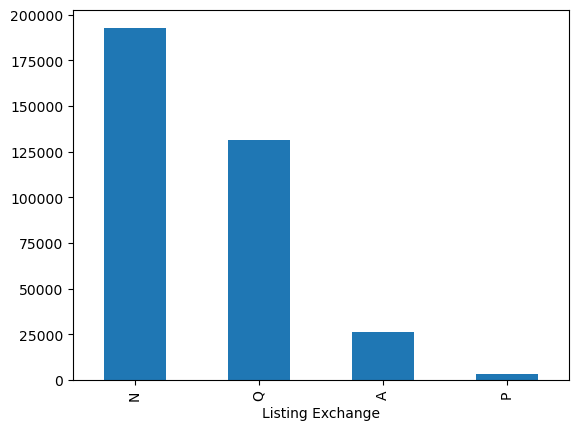

In [21]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [24]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(drop = 'first')
onehot.fit(df[['Listing Exchange']])

OneHotEncoder(drop='first')

In [ ]:
listing_enc = onehot.fit_transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [28]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [29]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [30]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [31]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [32]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5562714837395499,
 'accuracy_score_test': 0.5543971821821114,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'log_loss_train': 0.6845910819467869,
 'log_loss_test': 0.6846561556654359,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [33]:
from sklearn.compose import ColumnTransformer

In [35]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric_transfomer',
                                                  StandardScaler(),
                                                  ['returns', 'Volume', 'op_cl',
                                                   'hi_lo']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Listing Exchange',
                                                   'Market Category'])])),
                ('decisiontree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [36]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [37]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [38]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6715657749289736,
 'log_loss_test': 0.6723997441422311,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'f1_score_train': 0.0,
 'f1_score_test': 0.0,
 'accuracy_score_train': 0.5564701149780963,
 'accuracy_score_test': 0.555476969321899}

In [39]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6280724420765472,
 'log_loss_test': 1.4183453336667287,
 'cohen_kappa_train': np.float64(0.1599048351040816),
 'cohen_kappa_test': np.float64(0.07437568336516653),
 'f1_score_train': 0.5028514246363088,
 'f1_score_test': 0.4537912405942504,
 'accuracy_score_train': 0.5915161106371316,
 'accuracy_score_test': 0.549482804349748}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [40]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [41]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,7.309685,0.383552,0.549008,0.591459,0.397771,0.473071,0.488698,0.553684,0.335372,0.412948,0.563535,0.640800,-2.253582,-0.630182,-0.263369,-0.224506
1,6.541224,0.323236,0.520575,0.592488,0.402595,0.501447,0.450724,0.549012,0.363752,0.461467,0.519274,0.642890,-2.075579,-0.630486,-0.270807,-0.224410
2,5.438208,0.360960,0.521636,0.592605,0.494688,0.515653,0.465914,0.546229,0.527250,0.488318,0.529703,0.644653,-1.084408,-0.630216,-0.254997,-0.224090
3,6.058921,0.375316,0.540916,0.591858,0.400000,0.449372,0.476669,0.560516,0.344577,0.375012,0.552732,0.642738,-2.291734,-0.628199,-0.267657,-0.223764
4,5.991154,0.462571,0.556519,0.583396,0.421387,0.443044,0.500965,0.545244,0.363625,0.373109,0.577350,0.628128,-1.354475,-0.637587,-0.250793,-0.227276


In [42]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,5.963374,0.355443,0.549177,0.591498,0.398838,0.473152,0.489014,0.553735,0.336742,0.413043,0.563900,0.640857,-2.255560,-0.630157,-0.263389,-0.224492
1,6.875841,0.513497,0.520349,0.592552,0.403280,0.501534,0.450588,0.549096,0.364963,0.461554,0.519223,0.642991,-2.066478,-0.630419,-0.270637,-0.224384
2,6.163813,0.321270,0.521296,0.592686,0.494495,0.516836,0.465598,0.546112,0.527218,0.490540,0.529601,0.644753,-1.078810,-0.630172,-0.254844,-0.224070
3,7.409842,0.276444,0.541242,0.591823,0.399215,0.449498,0.477065,0.560409,0.343208,0.375235,0.553120,0.642678,-2.283808,-0.628317,-0.267343,-0.223797
4,5.657099,0.275496,0.556477,0.583403,0.421235,0.443111,0.500900,0.545244,0.363434,0.373204,0.577251,0.628131,-1.353955,-0.637604,-0.250779,-0.227276


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [43]:
pd.DataFrame(d15_dict).mean()

fit_time                 6.413994
score_time               0.348430
test_accuracy            0.537708
train_accuracy           0.590392
test_f1                  0.423413
train_f1                 0.476826
test_precision           0.476633
train_precision          0.550919
test_recall              0.387113
train_recall             0.422715
test_roc_auc             0.548619
train_roc_auc            0.639882
test_neg_log_loss       -1.807722
train_neg_log_loss      -0.631334
test_neg_brier_score    -0.261398
train_neg_brier_score   -0.224804
dtype: float64